<a href="https://colab.research.google.com/github/av-dutta/Book_Recommendation_System/blob/main/Books_ecommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Uploading nessessary libraries

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading data: Books,Ratings,Users dataset

In [3]:
book_path ="/content/drive/MyDrive/capstone Alma Better/data_book_recommendation/Books.csv"
ratings_path = "/content/drive/MyDrive/capstone Alma Better/data_book_recommendation/Ratings.csv"
users_path = "/content/drive/MyDrive/capstone Alma Better/data_book_recommendation/Users.csv"
book_df = pd.read_csv(book_path)
ratings_df = pd.read_csv(ratings_path)
users_df = pd.read_csv(users_path)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


##Exploring books dataset

In [4]:
book_df.head(2)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


In [5]:
#Changing names of columns since we have to 
book_df.rename({'Book-Title':'Title','Book-Author':'Author','Year-Of-Publication':'Year'},axis=1,inplace= True)

In [6]:
#Dropping the unnessassary columns
book_df.drop('Image-URL-S',axis=1,inplace=True)
book_df.drop('Image-URL-M',axis=1,inplace=True)
book_df.drop('Image-URL-L',axis=1,inplace=True)

In [7]:
#Checking Null Values
book_df.isnull().sum()

ISBN         0
Title        0
Author       1
Year         0
Publisher    2
dtype: int64

In [8]:
#Dropping null values across the rows
book_df.dropna(axis=0, inplace=True)

##Exploring ratings dataset

In [9]:
ratings_df.head(2)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5


In [10]:
#Renaming the columns for the ease of use
ratings_df.rename({'User-ID':'user_id','Book-Rating':'rating'},axis=1,inplace=True)

In [11]:
ratings_df.head(2)

,user_id,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5


In [12]:
#Checking null values in ratings dataset
ratings_df.isnull().sum()

user_id    0
ISBN       0
rating     0
dtype: int64

In [13]:
#Finding unique users in ratings dataset
ratings_df['user_id'].unique().shape

(105283,)

##Exploring users dataset

In [14]:
users_df.head(2)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


In [15]:
#Renaming features to make names similar to other datasets
users_df.rename({'User-ID':'user_id'},axis=1,inplace=True)

In [16]:
#Checking number of unique users present in the user dataset
users_df['user_id'].unique().shape

(278858,)

In [17]:
#Checking null values in the users dataset
users_df.isnull().sum()

user_id          0
Location         0
Age         110762
dtype: int64

It seems there is a lot of null values in the Age column, Since our model cannot work with null values so we can remove it rowwise

In [18]:
users_df.dropna(axis =0, inplace =True)

In [19]:
len(ratings_df['user_id'].unique())/(len(users_df['user_id'].unique()) + (len(ratings_df['user_id'].unique())))

0.385117364537876

So roughly 40% of unique users gives review for the books.

In [20]:
# Joining users and ratings dataframe
ur_df = pd.merge(users_df,ratings_df,on= 'user_id')

In [21]:
#User and rating dataframe 
ur_df.head()

,user_id,Location,Age,ISBN,rating
0,2,"stockton, california, usa",18.0,0195153448,0
1,10,"albacete, wisconsin, spain",26.0,1841721522,0
2,10,"albacete, wisconsin, spain",26.0,8477024456,6
3,19,"weston, ,",14.0,0375759778,7
4,20,"langhorne, pennsylvania, usa",19.0,0425163091,0


In [22]:
#Checking the shape of the dataframe
ur_df.shape

(840288, 5)

In [23]:
#Null values of the new dataset
ur_df.isnull().sum()

user_id     0
Location    0
Age         0
ISBN        0
rating      0
dtype: int64

There is no null values in the user and rating combined dataframe

In [24]:
#User and rating dataset now merged with books dataset
rated_books = ur_df.merge(book_df,how = 'inner',on='ISBN')
rated_books.head(2)

,user_id,Location,Age,ISBN,rating,Title,Author,Year,Publisher
0,2,"stockton, california, usa",18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,10,"albacete, wisconsin, spain",26.0,1841721522,0,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd


In [25]:
#Null values in the new dataset
rated_books.isnull().sum()

user_id      0
Location     0
Age          0
ISBN         0
rating       0
Title        0
Author       0
Year         0
Publisher    0
dtype: int64

In this case also there are no such null values

In [26]:
# Checking the shape of the dataset so formed
rated_books.shape

(753298, 9)

In [27]:
rated_books['user_id'].nunique()

53887

So we have approximately 53.8k unique user ids with reviews

## Taking a copy of the datset

In [28]:
#Creating a copy of the rated book dataset for further use
rated_bookscopy = rated_books.copy()

In [29]:
rated_bookscopy.head(2)

,user_id,Location,Age,ISBN,rating,Title,Author,Year,Publisher
0,2,"stockton, california, usa",18.0,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,10,"albacete, wisconsin, spain",26.0,1841721522,0,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd


In [30]:
#Checking statistical summary of the rated books 
rated_bookscopy.describe([0.9,0.95,0.99]).transpose()

,count,mean,std,min,50%,90%,95%,99%,max
user_id,753298.0,141231.317098,78828.553360,2.0,141493.0,248718.0,263641.0,274808.0,278852.0
Age,753298.0,37.397625,14.098256,0.0,35.0,54.0,59.0,69.0,244.0
rating,753298.0,2.768898,3.864231,0.0,0.0,9.0,10.0,10.0,10.0


Since minimum age is 0 and max age is 244, both are likely to be impossible. So we can remove those particular rows in order to clean our dataset.

In [31]:
#Considering the minimum age for a user to read books is 12 and that of highest age to be 75
rated_bookscopy = rated_bookscopy[(rated_bookscopy['Age'] > 12) & (rated_bookscopy['Age'] < 75)]

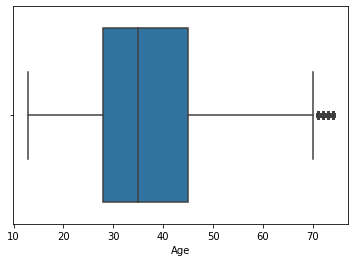

In [32]:
#Creating a boxplot on the Age column in the rated books dataset
import seaborn as sns
sns.boxplot(x='Age',data = rated_bookscopy)

This shows there are only four ourlier values in the age column, But we are not removing those since are model will not be much affected by this.

## <u> Data Processing

### Recommender systems have a problem known as user cold-start, in which it is hard to provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.  

### For this reason, we are keeping in the dataset only users with at least 100 interactions.

In [33]:
user_id_count_df = rated_books.groupby(['user_id','ISBN']).size().groupby('user_id').size()
print('# of users: %d' % len(user_id_count_df))

users_with_enough_count_df = user_id_count_df[user_id_count_df >= 100].reset_index()[['user_id']]
print('# of users with at least 100 interactions: %d' % len(users_with_enough_count_df))

# of users: 53887
# of users with at least 100 interactions: 1310


This shows 1310 unique users are there which has minimum 100 interactions.

In [34]:
user_id_count_df.head()

user_id
2     1
10    1
19    1
20    1
36    1
dtype: int64

In [35]:
print('# of interactions: %d' % len(rated_bookscopy))
interactions_from_selected_users_df = rated_bookscopy.merge(users_with_enough_count_df, 
               how = 'right',
               left_on = 'user_id',
               right_on = 'user_id')
print('# of interactions from users with at least 100 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 742274
# of interactions from users with at least 100 interactions: 451073


We are using right join to create a new dataframe with the details of the users having enough interaction count.

In [36]:
interactions_from_selected_users_df.isnull().sum()

user_id       0
Location     16
Age          16
ISBN         16
rating       16
Title        16
Author       16
Year         16
Publisher    16
dtype: int64

In [37]:
interactions_from_selected_users_df.dropna(axis=0,inplace=True)

In [38]:
interactions_from_selected_users_df['rating'].unique()

array([ 0.,  7.,  9.,  5.,  6.,  4.,  8., 10.,  3.,  1.,  2.])

Ratings column has values ranging from 0 to 10.

###Since in a platform a person is expected to rate a book one time only,so we can consider the rating values as strength of each rating

In [39]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df.groupby(['user_id', 'ISBN'])['rating'].sum().apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()

# of unique user/item interactions: 451057


,user_id,ISBN,rating
0,254,006000438X,0.0
1,254,0060013117,0.0
2,254,0060199563,0.0
3,254,0060391448,0.0
4,254,0060502320,3.0


### Splitting data into train and test dataset

In [40]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['user_id'], 
                                   test_size=0.20,
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 360845
# interactions on Test set: 90212


In [41]:
#our test dataset
interactions_test_df.head()

,user_id,ISBN,rating
2553,3363,0451408888,0.000000
75070,52614,0373691327,3.321928
195006,124079,0553571885,0.000000
76591,52917,0874831938,2.584963
291579,180651,0446604534,0.000000


In [42]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='user_id', 
                                                          columns='ISBN', 
                                                          values='rating').fillna(0)

users_items_pivot_matrix_df.head()

ISBN,0000913154,0001047663,0001047868,000104799X,0001048082,0001052039,0001055607,0001056107,000123207X,0001232088,000171421X,0001811150,0001821326,0001845039,0001848461,0001900277,0001939203,0001941941,0001941968,0001944711,0001944835,0001945203,0001952803,0001953877,000195833X,0001961721,0001981307,0001981625,0002000547,0002005018,0002005050,0002005557,0002111314,0002113570,0002115328,0002116286,0002153572,0002154064,0002156083,0002157853,...,B00009APKU,B00009EF82,B00009MBYK,B00009NDAN,B00009ZWDN,B0000A2U93,B0000C2W5U,B0000C2W66,B0000C37EK,B0000C7BMU,B0000C7BNG,B0000DYXID,B0000E63CJ,B0000T6KHI,B0000T6KIM,B0000VZEFK,B0000VZEH8,B0000VZEJQ,B0000X8HIE,B00011SOXI,B00013AFZQ,B00013AWVI,B00013AWZY,B00013AX6W,B00013AX9E,B00016560C,B00016560M,B00017IWGQ,B000199D26,B0001FZGPI,B0001FZGRQ,B0001FZGTO,B0001GDNCK,B0001GMSV2,B0001I1JII,B0001PBXMS,B0001PIOX4,B000234N3A,B000234N76,B00029DGGO
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1435,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
users_items_pivot_matrix_df.isnull().sum()

ISBN
0000913154    0
0001047663    0
0001047868    0
000104799X    0
0001048082    0
             ..
B0001PBXMS    0
B0001PIOX4    0
B000234N3A    0
B000234N76    0
B00029DGGO    0
Length: 146015, dtype: int64

In [44]:
users_items_pivot_matrix_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 254 to 278188
Columns: 146015 entries, 0000913154 to B00029DGGO
dtypes: float64(146015)
memory usage: 1.4 GB


### Converting table into sparse matrix

In [45]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [46]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[254, 882, 1435, 1733, 1903, 2033, 2276, 2358, 2766, 2977]

In [47]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 20

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

Here k is a hyperparameter which can be tuned in order to optimize our model

In [48]:
#Shape of the original matrix
users_items_pivot_matrix.shape

(1294, 146015)

In [49]:
U

array([[-4.34279567e-03, -7.59920214e-03,  3.52962746e-03, ...,
         8.73735644e-03,  3.17126299e-03, -7.00209435e-04],
       [ 2.14871364e-03,  1.97664933e-03, -3.84807421e-03, ...,
         4.19247491e-03,  2.55483497e-03, -2.43530459e-04],
       [ 1.00595962e-03, -7.13781634e-04, -1.56823700e-03, ...,
         7.00568733e-03,  5.25485587e-04, -4.03386883e-05],
       ...,
       [ 3.04272330e-04, -3.82403306e-03, -1.45851473e-03, ...,
         4.35114075e-03,  1.11748584e-03, -3.32242903e-05],
       [-3.68539302e-03,  2.12877813e-03,  9.62387138e-04, ...,
         3.88671639e-03,  1.05065107e-03, -2.91766710e-05],
       [ 7.40600132e-04,  2.30714287e-05,  9.49423368e-04, ...,
         2.20197168e-03,  2.34221798e-03, -8.22709897e-04]])

In [50]:
U.shape

(1294, 20)

In [51]:
sigma = np.diag(sigma)
sigma.shape

(20, 20)

In [52]:
Vt.shape

(20, 146015)

### After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [53]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.0009655 ,  0.        ,  0.        , ...,  0.04088539,
         0.        ,  0.        ],
       [-0.00099869,  0.        ,  0.        , ...,  0.00819604,
         0.        ,  0.        ],
       [ 0.00281369,  0.        ,  0.        , ...,  0.00725599,
         0.        ,  0.        ],
       ...,
       [ 0.00567221,  0.        ,  0.        , ...,  0.00501174,
         0.        ,  0.        ],
       [ 0.00345618,  0.        ,  0.        , ...,  0.00066477,
         0.        ,  0.        ],
       [-0.00045891,  0.        ,  0.        , ..., -0.00056827,
         0.        ,  0.        ]])

In [54]:
all_user_predicted_ratings.shape

(1294, 146015)

In [55]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,254,882,1435,1733,1903,2033,2276,2358,2766,2977,3363,3371,3827,4017,4157,4385,5582,5903,6251,6323,6543,6563,7125,7158,7286,7346,8067,8245,8253,8284,8362,8487,8681,8890,8936,8971,9141,9417,9856,9908,...,268330,268622,268657,268833,268932,269321,269439,269719,269728,269890,270713,270820,270838,271195,271284,271448,271538,271705,272225,272482,272715,273086,273110,273113,273190,273718,273979,274004,274061,274301,274308,274808,275970,276463,276680,277427,277478,277639,278137,278188
ISBN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0000913154,0.000966,-0.000999,0.002814,-0.000990,-0.000403,0.012224,-0.000264,-0.000302,0.002851,-0.001153,-0.002406,0.003874,0.010936,-0.000585,-0.000907,-0.000592,0.001852,-0.000922,0.005554,0.001155,0.020644,-0.005491,-0.002722,-0.002395,-0.001148,0.015418,-0.003470,-0.004603,-0.001134,-0.000246,-0.000570,0.004289,-0.004476,-0.000008,0.003373,-0.000220,-0.000146,0.003232,-0.001710,0.002800,...,-0.000089,-0.001873,-0.003550,-0.000683,0.008008,-0.000453,-0.000752,-0.000881,-0.000439,-0.002191,-0.009233,-0.005243,-0.001448,0.008325,-0.000569,-0.010556,-0.001379,0.010458,-0.001577,-0.000140,0.003295,-0.001660,-0.000472,-0.001038,0.003288,-0.001255,-0.003838,-0.003323,-0.004203,0.004930,-0.002592,0.002917,0.002161,-0.001354,-0.003318,0.006341,-0.000146,0.005672,0.003456,-0.000459
0001047663,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0001047868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
000104799X,0.002648,0.001255,0.001554,0.000726,0.000733,0.001809,0.001740,0.000187,0.003433,0.001072,0.002252,0.000968,0.001699,0.007094,0.000912,0.000276,0.003219,0.000745,0.008658,0.000895,0.005568,0.005839,0.003242,0.001999,0.001043,0.015465,0.003324,0.004786,0.006241,0.000160,0.000652,0.000152,0.002779,0.000015,0.000655,0.000074,0.000113,0.000885,0.001837,0.001221,...,0.000096,0.002508,0.002417,0.000843,0.002099,0.000254,0.000737,0.000464,0.000447,0.002373,0.009069,0.003425,0.001252,0.002895,0.000234,0.009825,0.001133,0.006779,0.001085,0.000118,0.001037,0.001575,0.000285,0.001599,0.001057,0.001235,0.003349,0.003150,0.002318,0.005438,0.002467,0.001448,0.003102,0.000977,0.003103,0.003340,0.000141,0.000785,0.001180,0.000383
0001048082,0.002575,0.000864,0.001013,0.000791,0.000249,0.002512,0.002639,0.000129,0.001905,0.000645,0.000824,0.001342,0.001408,0.001584,0.000563,0.000385,0.001634,0.000277,0.005756,0.000855,0.002885,0.002938,0.001000,0.003514,0.000684,0.011425,0.001696,0.001521,0.003873,0.000122,0.000406,0.000117,0.001270,0.000008,0.001292,0.000032,-0.000049,0.001515,0.002002,0.001023,...,0.000153,0.001515,0.001641,0.000432,0.002358,-0.000755,0.0004

In [56]:
cf_preds_df.shape

(146015, 1294)

In [57]:
len(cf_preds_df.columns)

1294

In [58]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'ISBN', 
                                                          right_on = 'ISBN')[['recStrength', 'ISBN', 'Title', 'Author','Image-URL-S','Image-URL-M','Image-URL-L', 'Age','Year']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, rated_bookscopy)

# Evaluation

### In Recommender Systems, there are a set metrics commonly used for evaluation. We choose to work with **Top-N accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

### This evaluation method works as follows:

* ### For each user
    * ### For each item the user has interacted in test set
        * ### Sample 100 other items the user has never interacted.   
        * ### Ask the recommender model to produce a ranked list of recommended items, from a set composed of one interacted item and the 100 non-interacted items
        * ### Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
* ### Aggregate the global Top-N accuracy metrics

In [59]:
#Indexing by user_id to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('user_id')
interactions_train_indexed_df = interactions_train_df.set_index('user_id')
interactions_test_indexed_df = interactions_test_df.set_index('user_id')

In [60]:
interactions_full_indexed_df.isnull().sum()

ISBN      0
rating    0
dtype: int64

In [61]:
interactions_train_indexed_df.isnull().sum()

ISBN      0
rating    0
dtype: int64

In [62]:
interactions_test_indexed_df.isnull().sum()

ISBN      0
rating    0
dtype: int64

### The Top-N accuracy metric choosen was **Recall@N** which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.

In [63]:
def get_items_interacted(user_id, interactions_df):
    interacted_items = interactions_df.loc[user_id]['ISBN']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [64]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, user_id, sample_size, seed=42):
        interacted_items = get_items_interacted(user_id, interactions_full_indexed_df)
        all_items = set(book_df['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, user_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[user_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(user_id, items_to_ignore=get_items_interacted(user_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #person_interacted_items_testset = are those which the person already visited
            #non_interacted_items_sample = set of not visited items 
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(user_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=0)

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ISBN'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ISBN'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        user_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return user_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, user_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            user_metrics = self.evaluate_model_for_user(model, user_id)  
            user_metrics['_user_id'] = user_id
            people_metrics.append(user_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

In [ ]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...


Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got **Recall@5 (32%)** and **Recall@10 (41%)** 

Here we user 26 has interacted with 1291 items and out of which each of 225 items came from top 5 recommendation.